In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="O5hDeMQaybBKf51Z2CIT")
project = rf.workspace("adpm").project("ulcer-noise")
version = project.version(5)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Ulcer-Noise-5 in folder:: 100%|██████████| 5604/5604 [00:01<00:00, 5332.04it/s]


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, f1_score, matthews_corrcoef, accuracy_score)
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from google.colab import files  # ✅ For downloading the model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 30
batch_size = 64
learning_rate = 0.001

# Data transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset loading
dataset = version.download("folder")
dataset_path = dataset.location

train_dataset = ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
val_dataset = ImageFolder(root=os.path.join(dataset_path, "valid"), transform=transform)

# ✅ Ensure binary classification
assert len(train_dataset.classes) == 2, "This script is intended for binary classification (2 classes only)."

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Handle class imbalance
labels = [label for _, label in train_dataset.samples]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Load pretrained ResNet50 and freeze early layers
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# ✅ Replace final layer for 2-class classification
num_classes = 2
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Parallelize and move to device
model = torch.nn.DataParallel(model)
model = model.to(device)

# Loss, optimizer, scheduler
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# ✅ Model save paths
save_state_dict_path = "/content/best_model_binary.pth"
save_full_model_path = "/content/best_model_binary_full.pth"
best_combined_score = 0.0

# Label smoothing
def label_smoothed_nll_loss(lprobs, target, eps):
    nll_loss = -lprobs.gather(dim=-1, index=target.unsqueeze(-1)).squeeze(-1).mean()
    smooth_loss = -lprobs.mean(dim=-1).mean()
    return (1. - eps) * nll_loss + eps * smooth_loss

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        log_probs = F.log_softmax(outputs, dim=1)

        loss = label_smoothed_nll_loss(log_probs, labels, eps=0.1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            outputs = model(val_inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            val_correct += (preds == val_labels).sum().item()
            val_total += val_labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    try:
        auc = roc_auc_score(all_labels, [p[1] for p in all_probs])
    except ValueError:
        auc = 0.0
    mcc = matthews_corrcoef(all_labels, all_preds)
    conversion_rate = val_correct / val_total
    combined_score = accuracy + f1 + auc + mcc

    print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}, MCC: {mcc:.4f}, Conversion Rate: {conversion_rate:.4f}")

    if combined_score > best_combined_score:
        best_combined_score = combined_score
        torch.save(model.state_dict(), save_state_dict_path)
        torch.save(model, save_full_model_path)  # ✅ Full model save
        print("✅ Best model saved with combined score:", combined_score)

    scheduler.step()

print("\nTraining complete. Loading best model for final evaluation...")

# ✅ Load full model for evaluation
model = torch.load(save_full_model_path)
model.eval()

# Final evaluation
all_preds, all_labels = [], []
with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        outputs = model(val_inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(val_labels.cpu().numpy())

print("\n📊 Final Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Best Binary Model")
plt.show()

# ✅ Automatically download the best model (both versions)
files.download(save_state_dict_path)
files.download(save_full_model_path)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]



Epoch [1/30], Loss: 0.4956
Accuracy: 0.8158, F1: 0.8167, AUC: 0.9163, MCC: 0.6198, Conversion Rate: 0.8158
✅ Best model saved with combined score: 3.168638047925163

Epoch [2/30], Loss: 0.4130
Accuracy: 0.9211, F1: 0.9208, AUC: 0.9687, MCC: 0.8341, Conversion Rate: 0.9211
✅ Best model saved with combined score: 3.644659328787613

Epoch [3/30], Loss: 0.3975
Accuracy: 0.8684, F1: 0.8680, AUC: 0.9478, MCC: 0.7233, Conversion Rate: 0.8684

Epoch [4/30], Loss: 0.3817
Accuracy: 0.8684, F1: 0.8688, AUC: 0.9489, MCC: 0.7265, Conversion Rate: 0.8684

Epoch [5/30], Loss: 0.3721
Accuracy: 0.9013, F1: 0.9015, AUC: 0.9641, MCC: 0.7941, Conversion Rate: 0.9013

Epoch [6/30], Loss: 0.3649
Accuracy: 0.8882, F1: 0.8888, AUC: 0.9549, MCC: 0.7711, Conversion Rate: 0.8882

Epoch [7/30], Loss: 0.3630
Accuracy: 0.9013, F1: 0.9005, AUC: 0.9524, MCC: 0.7924, Conversion Rate: 0.9013

Epoch [8/30], Loss: 0.3614
Accuracy: 0.9079, F1: 0.9076, AUC: 0.9708, MCC: 0.8064, Conversion Rate: 0.9079

Epoch [9/30], Loss:

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.parallel.data_parallel.DataParallel was not an allowed global by default. Please use `torch.serialization.add_safe_globals([DataParallel])` or the `torch.serialization.safe_globals([DataParallel])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [4]:
import torch
from torch.nn import DataParallel
from torch.serialization import add_safe_globals

add_safe_globals([DataParallel])

model = torch.load('/content/best_model_binary_full.pth', weights_only=False)


In [1]:
import torch
import torchvision.models as models
from torch.serialization import add_safe_class

# Register ResNet model class
add_safe_class(models.resnet.ResNet)

# === Load full model ===
MODEL_PATH = "/content/best_model_binary_full.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the full model (not just state_dict)
try:
    resnet_model = torch.load(MODEL_PATH, map_location=DEVICE)
    resnet_model.to(DEVICE)
    resnet_model.eval()
    print("✅ Full model loaded successfully.")
except Exception as e:
    raise RuntimeError("❌ Failed to load full model.") from e

# Run dummy test
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)
    output = resnet_model(dummy_input)
    pred_class = output.argmax().item()
    print("Dummy prediction:", pred_class)


ImportError: cannot import name 'add_safe_class' from 'torch.serialization' (/usr/local/lib/python3.11/dist-packages/torch/serialization.py)

In [9]:
import torch
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict

# Config
NUM_CLASSES = 2  # Change to 4 if multiclass
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/content/best_model_binary.pth"

# Step 1: Define the model architecture
resnet_model = models.resnet50(weights=None)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, NUM_CLASSES)
resnet_model.to(DEVICE)

# Step 2: Load state_dict and remove 'module.' prefix
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
new_state_dict = OrderedDict()

for k, v in state_dict.items():
    name = k.replace("module.", "")  # remove 'module.' prefix
    new_state_dict[name] = v

resnet_model.load_state_dict(new_state_dict)
resnet_model.eval()

print("✅ Model loaded successfully without 'module.' prefix.")

# Step 3: Dummy prediction test
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)
    output = resnet_model(dummy_input)
    pred = output.argmax(dim=1).item()
    print("Dummy prediction class:", pred)


✅ Model loaded successfully without 'module.' prefix.
Dummy prediction class: 0


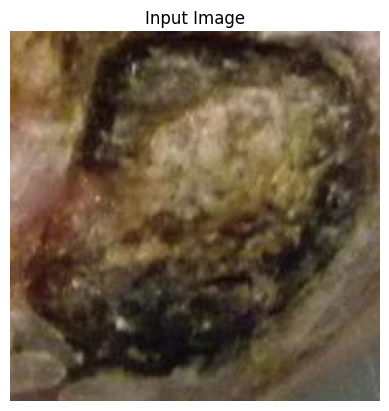

🧠 Predicted Class: Grade 0


In [17]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# === CONFIG ===
IMAGE_PATH = "/content/Test2.jpg"  # <-- Change this to your image path
CLASS_NAMES = ["Grade 0", "Grade 1"]  # Your actual class names
IMG_SIZE = 224  # Match training size

# === TRANSFORM (same as validation) ===
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === LOAD & PREDICT ===
img = Image.open(IMAGE_PATH).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(DEVICE)

# Show the image
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")
plt.show()

# Predict
with torch.no_grad():
    output = resnet_model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    print(f"🧠 Predicted Class: {CLASS_NAMES[pred_class]}")


✅ Validation Accuracy: 88.82%


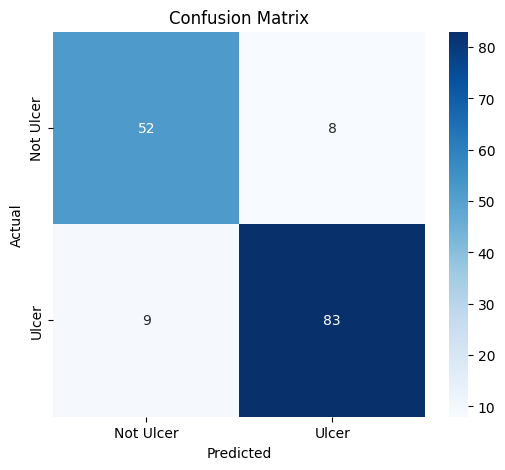

In [18]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np

# === CONFIG ===
MODEL_PATH = "/content/best_model_binary.pth"      # 🔁 Path to your model
VAL_DIR = "/content/Ulcer-Noise-5/valid"                           # 🔁 Path to validation images (with class subfolders)
NUM_CLASSES = 2
CLASS_NAMES = ["Not Ulcer", "Ulcer"]
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Step 1: Load model ===
resnet_model = models.resnet50(weights=None)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, NUM_CLASSES)
resnet_model.to(DEVICE)

state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_state_dict[k.replace("module.", "")] = v

resnet_model.load_state_dict(new_state_dict)
resnet_model.eval()

# === Step 2: Data loader ===
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# === Step 3: Evaluate ===
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet_model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Step 4: Accuracy & Confusion Matrix ===
acc = accuracy_score(all_labels, all_preds)
print(f"✅ Validation Accuracy: {acc*100:.2f}%")

# Optional: Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
